# **Goalkeeper Performance Analysis — Unsupervised Learning**

# 1. Introduction

This notebook explores goalkeeper statistics using unsupervised learning.  
We'll perform:
1. Descriptive Statistics & Data Exploration  
2. Feature Engineering  
3. Factorial Analysis (PCA)  
4. Clustering (K-Means)  
5. Deep Dive / Interpretation

*Tools Used:*
- pandas: data manipulation
- matplotlib, seaborn: visualization
- scikit-learn: PCA, clustering, scaling

**Importing libraries**

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

In [74]:
# Configuration class to keep our paths and column names organized
class Config:
    path = "../data/"
    
sns.set_context("talk")

**Loading datasets and extracting data concerning goalkeepers**
- goalkeeping.csv
- distribution.csv
- disciplinary.csv
- key_stats.csv

In [75]:
# Store the filenames in a dictionary
files = {
    "goalkeeping": "goalkeeping.csv",
    "distribution": "distributon.csv",
    "disciplinary": "disciplinary.csv",
    "key_stats": "key_stats.csv"
}

# Read all datasets into a dictionary of DataFrames
dataframes = {name: pd.read_csv(Config.path + filename) for name, filename in files.items()}

# extracting goalkeepers in each dataframe
goalkeepers = {name: df[df['position'] == 'Goalkeeper'] for name, df in dataframes.items()}

# deleting the serial and position columns in all dataframes if it exists
for name in goalkeepers:
    if 'serial' in goalkeepers[name].columns:
        goalkeepers[name] = goalkeepers[name].drop(columns=['serial'])
    if 'position' in goalkeepers[name].columns:
        goalkeepers[name] = goalkeepers[name].drop(columns=['position'])

# merging all dataframes on 'player_name', 'club' and 'match_played'
for name in goalkeepers:
    if name != 'goalkeeping':
        goalkeepers['goalkeeping'] = pd.merge(goalkeepers['goalkeeping'], goalkeepers[name], on=['player_name', 'club', 'match_played'], how='left')
        
# sorting the final dataframe
df = goalkeepers['goalkeeping'].sort_values('player_name').reset_index(drop=True)

**Datasets Overview**

In [76]:
# Display the shape of each dataframe
for name in goalkeepers:
    print(f"{name} dataset shape: {goalkeepers[name].shape}")

print(f"Merged goalkeeping dataset shape: {df.shape}")

goalkeeping dataset shape: (53, 24)
distribution dataset shape: (50, 10)
disciplinary dataset shape: (2, 8)
key_stats dataset shape: (54, 7)
Merged goalkeeping dataset shape: (53, 24)


In [77]:
# Display the first few rows of each DataFrame
for name in goalkeepers:
    print(f"\n{name} dataset preview:")
    print(goalkeepers[name].head())

print("\nMerged goalkeeping dataset preview:")    
print(df.head())


goalkeeping dataset preview:
    player_name         club  saved  conceded  saved_penalties  cleansheets  \
0      Courtois  Real Madrid     61        14                1            5   
1         Rulli   Villarreal     41        16                0            3   
2   Vlachodimos      Benfica     38        17                1            5   
3  Athanasiadis      Sheriff     29         8                0            1   
4      Mignolet  Club Brugge     28        20                0            0   

   punches made  match_played  pass_accuracy  pass_attempted  ...  \
0             4            13           76.7           483.0  ...   
1            12            12           68.2           489.0  ...   
2             5            10           73.8           345.0  ...   
3             2             5           69.2           154.0  ...   
4             1             6           78.7           216.0  ...   

   freekicks_taken  fouls_committed  fouls_suffered  red  yellow  \
0           

In [78]:
# Display the last few rows of each DataFrame
for name in goalkeepers:
    print(f"\n{name} dataset tail:")
    print(goalkeepers[name].tail())
    
print("\nMerged goalkeeping dataset tail:")
print(df.tail())


goalkeeping dataset tail:
   player_name              club  saved  conceded  saved_penalties  \
48    Martínez           Leipzig      3         0                0   
49       Onana              Ajax      2         2                0   
50       Perin          Juventus      2         0                0   
51  Shevchenko  Shakhtar Donetsk      1         1                0   
52      Carson         Man. City      1         0                0   

    cleansheets  punches made  match_played  pass_accuracy  pass_attempted  \
48            1             0             1           54.0            28.0   
49            0             0             2           88.0            56.0   
50            1             0             1           79.0            19.0   
51            0             0             1            NaN             NaN   
52            1             0             1            NaN             NaN   

    ...  freekicks_taken  fouls_committed  fouls_suffered  red  yellow  \
48  ...  

# 2. Descriptive Statistics / Data Exploration / Feature Engineering

In [79]:
# Basic info about the merged dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   player_name       53 non-null     object 
 1   club              53 non-null     object 
 2   saved             53 non-null     int64  
 3   conceded          53 non-null     int64  
 4   saved_penalties   53 non-null     int64  
 5   cleansheets       53 non-null     int64  
 6   punches made      53 non-null     int64  
 7   match_played      53 non-null     int64  
 8   pass_accuracy     50 non-null     float64
 9   pass_attempted    50 non-null     float64
 10  pass_completed    50 non-null     float64
 11  cross_accuracy    50 non-null     float64
 12  cross_attempted   50 non-null     float64
 13  cross_complted    50 non-null     float64
 14  freekicks_taken   50 non-null     float64
 15  fouls_committed   2 non-null      float64
 16  fouls_suffered    2 non-null      float64
 17 

In [80]:
# Descriptive statistics of the merged dataframe
print(df.describe().T)

                  count        mean         std    min      25%     50%  \
saved              53.0   13.528302   11.025502    1.0    5.000   13.00   
conceded           53.0    7.169811    5.158025    0.0    3.000    6.00   
saved_penalties    53.0    0.113208    0.319878    0.0    0.000    0.00   
cleansheets        53.0    1.320755    1.541398    0.0    0.000    1.00   
punches made       53.0    2.075472    2.622749    0.0    0.000    1.00   
match_played       53.0    4.773585    3.394801    1.0    2.000    5.00   
pass_accuracy      50.0   77.092000   11.083005   50.7   70.625   77.65   
pass_attempted     50.0  160.020000  120.772765   19.0   58.500  153.50   
pass_completed     50.0  123.220000   96.178467   15.0   48.250  103.50   
cross_accuracy     50.0    0.000000    0.000000    0.0    0.000    0.00   
cross_attempted    50.0    0.020000    0.141421    0.0    0.000    0.00   
cross_complted     50.0    0.000000    0.000000    0.0    0.000    0.00   
freekicks_taken    50.0  

Number of duplicated rows: 0


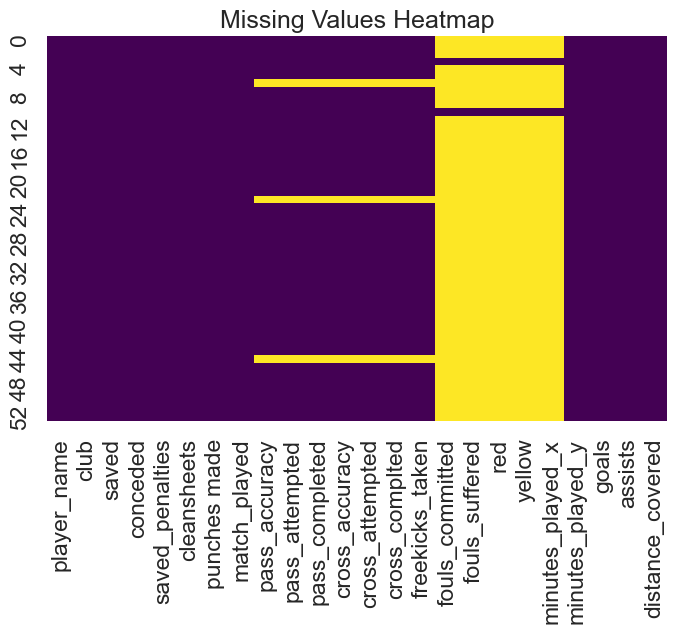

In [81]:
# Duplicated rows analysis
print(f"Number of duplicated rows: {df.duplicated().sum()}")

# Visualizing missing values
plt.figure(figsize=(8, 5))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [82]:
# Converting appropriate columns to numeric types
df['distance_covered'] = pd.to_numeric(df['distance_covered'], errors='coerce')

**Handling missing data and taking care of duplicated columns**

- Duplicated columns that occur due to merging will be dropped since they contain the same information
- The missing values are replaced with 0 because they are *structurally missing data*. For example not all goalkeepers recieved yellow or red cards.

In [83]:
#df = df.dropna(axis=1, thresh=int(0.7 * len(df)))  # Drop columns with more than 30% missing values
df.drop(columns=['minutes_played_x'], inplace=True)
df.rename(columns={'minutes_played_y': 'minutes_played'}, inplace=True)

df = df.fillna(0)  # Fill remaining missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   player_name       53 non-null     object 
 1   club              53 non-null     object 
 2   saved             53 non-null     int64  
 3   conceded          53 non-null     int64  
 4   saved_penalties   53 non-null     int64  
 5   cleansheets       53 non-null     int64  
 6   punches made      53 non-null     int64  
 7   match_played      53 non-null     int64  
 8   pass_accuracy     53 non-null     float64
 9   pass_attempted    53 non-null     float64
 10  pass_completed    53 non-null     float64
 11  cross_accuracy    53 non-null     float64
 12  cross_attempted   53 non-null     float64
 13  cross_complted    53 non-null     float64
 14  freekicks_taken   53 non-null     float64
 15  fouls_committed   53 non-null     float64
 16  fouls_suffered    53 non-null     float64
 17 

**Vizualisation**

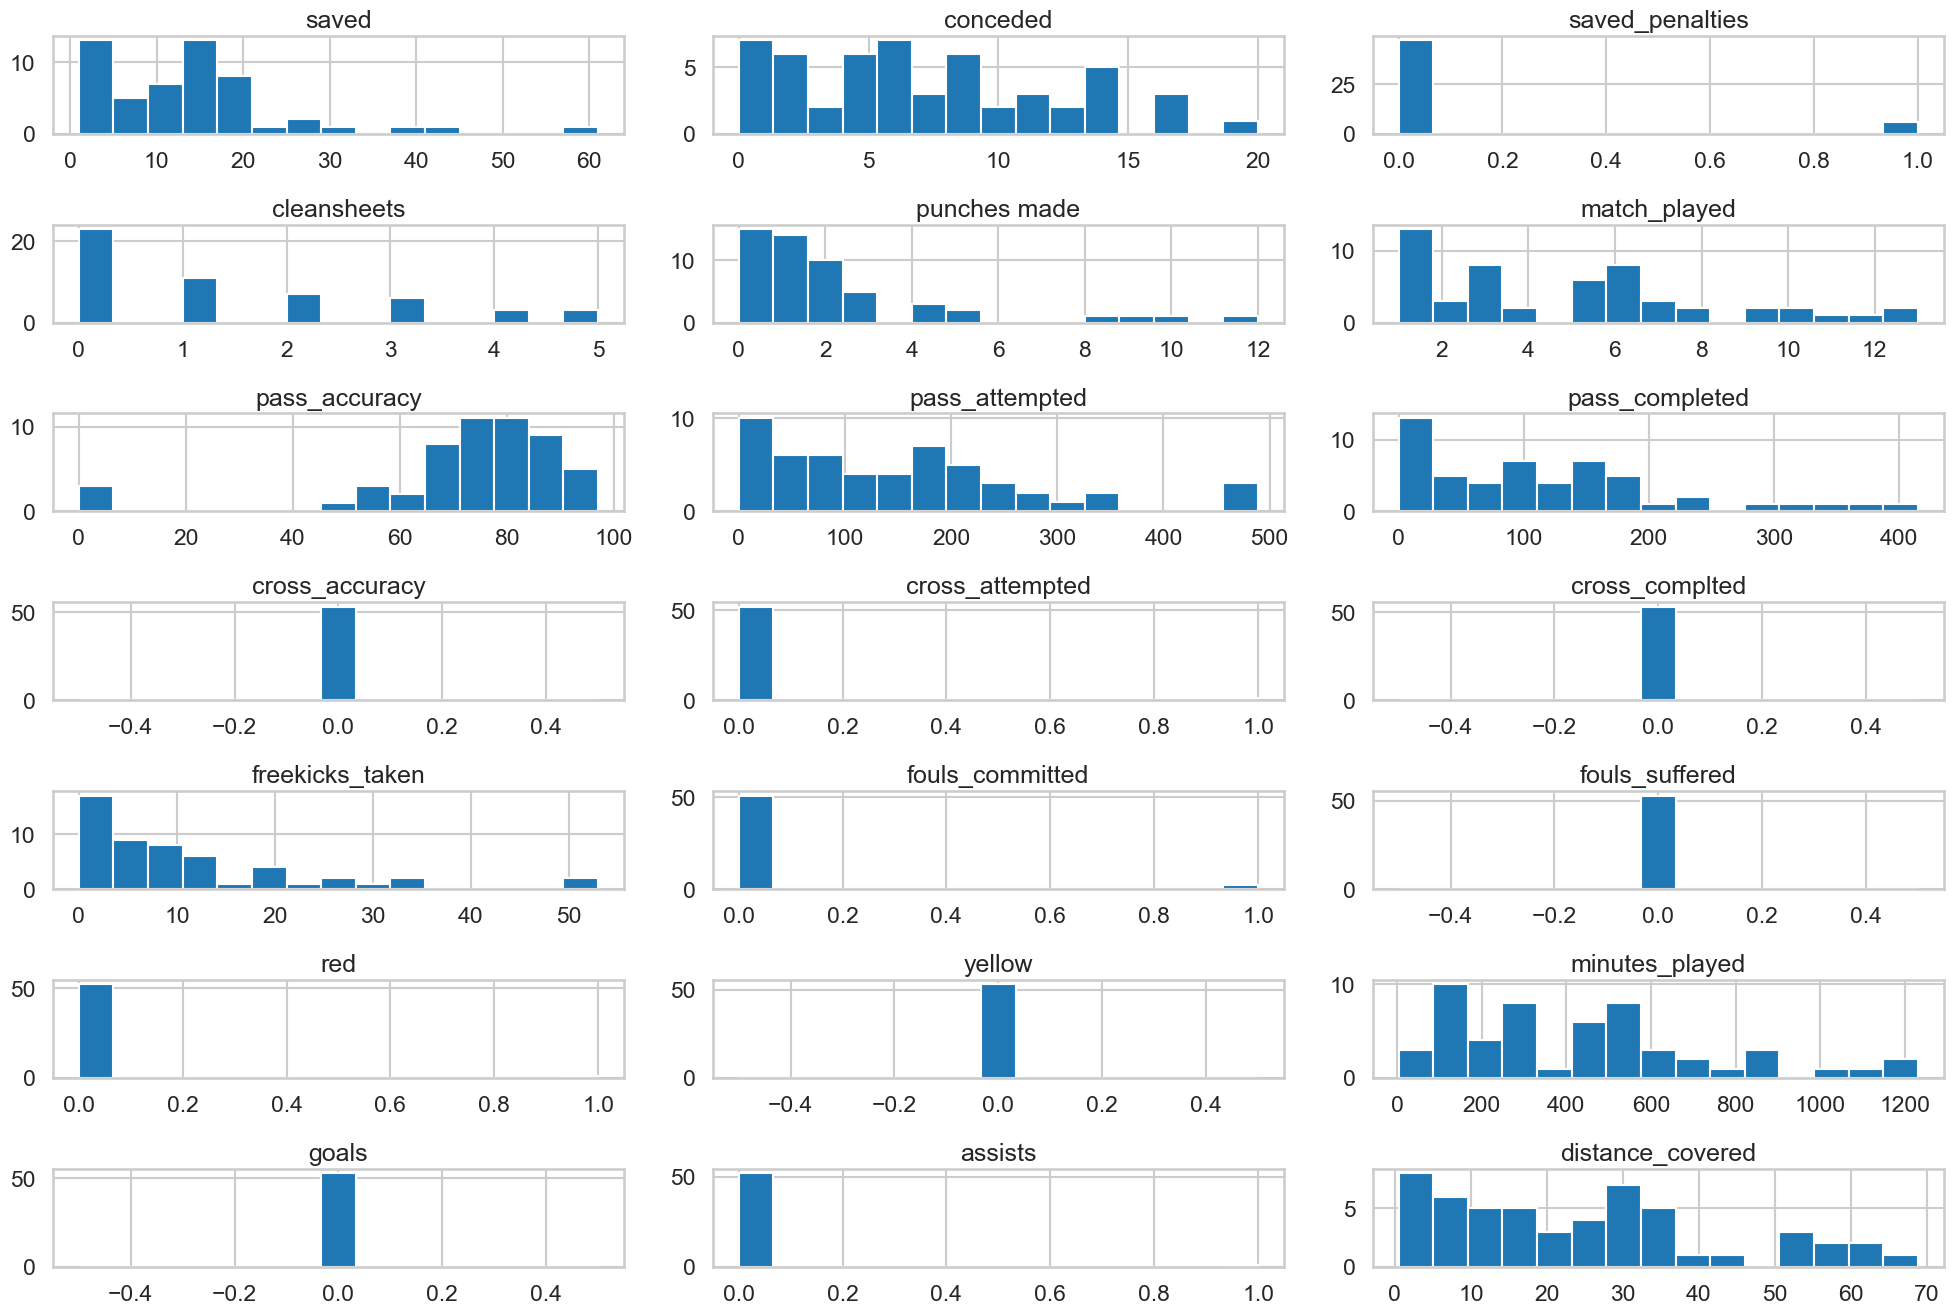

In [84]:
# Histogram of numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].hist(bins=15, figsize=(20, 15), layout=(len(numeric_cols)//3 + 1, 3))
plt.tight_layout()
plt.show()

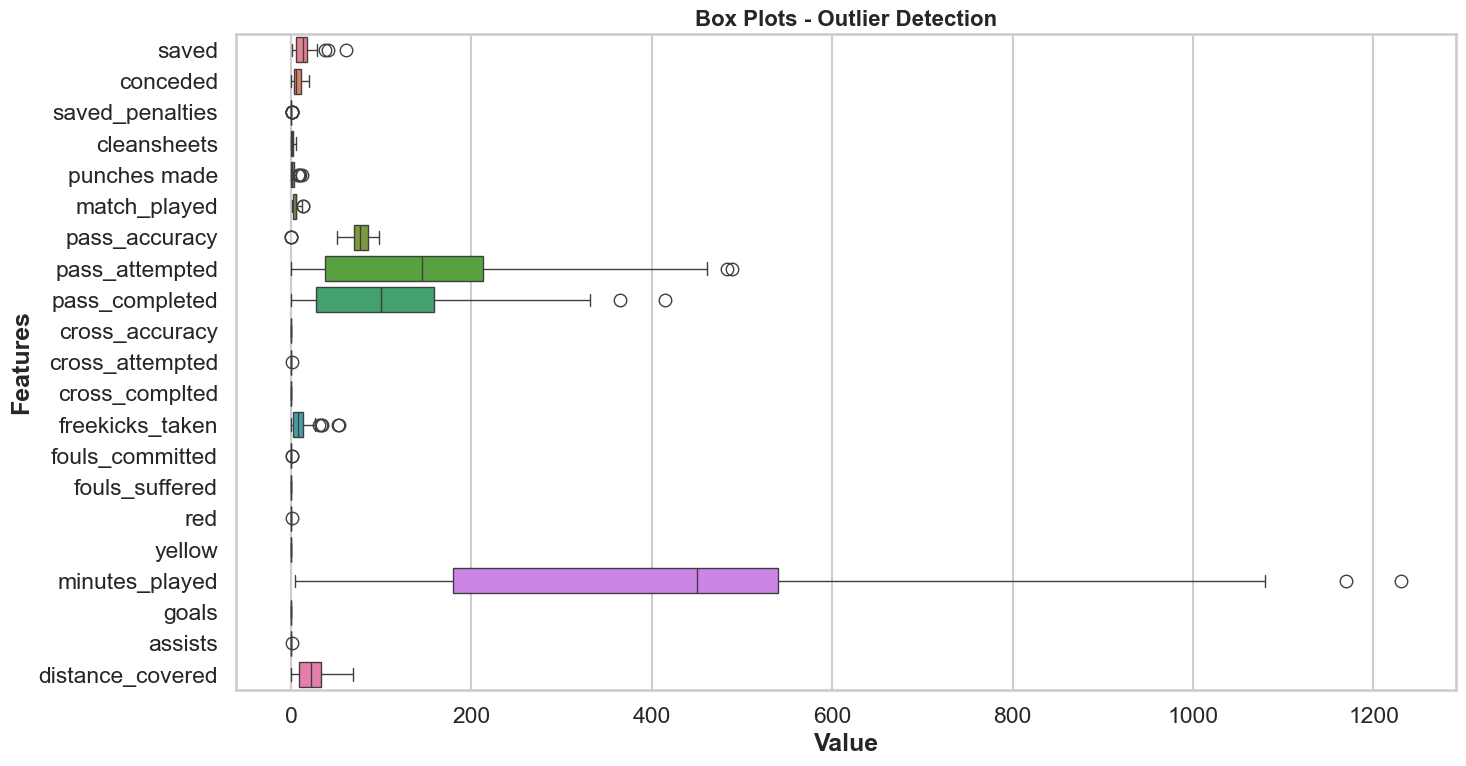

In [85]:
# Boxplots to detect outliers
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[numeric_cols], orient='h')
plt.xlabel('Value', fontweight='bold')
plt.ylabel('Features', fontweight='bold')
plt.title('Box Plots - Outlier Detection', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

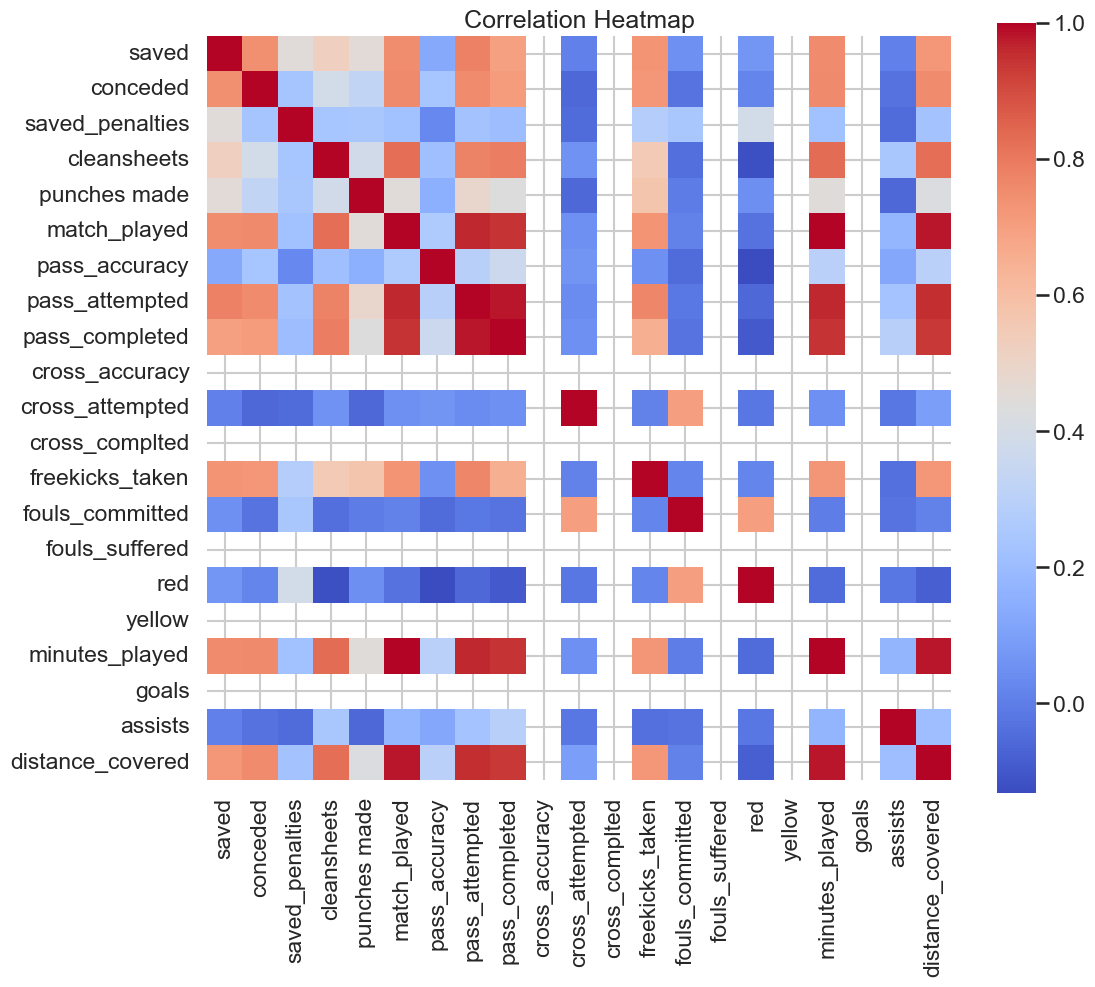

In [86]:
# Correlation matrix heatmap
plt.figure(figsize=(12,10))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.show()

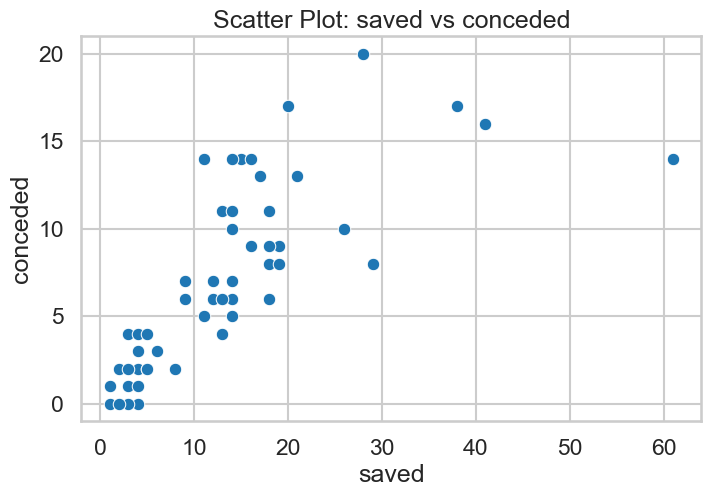

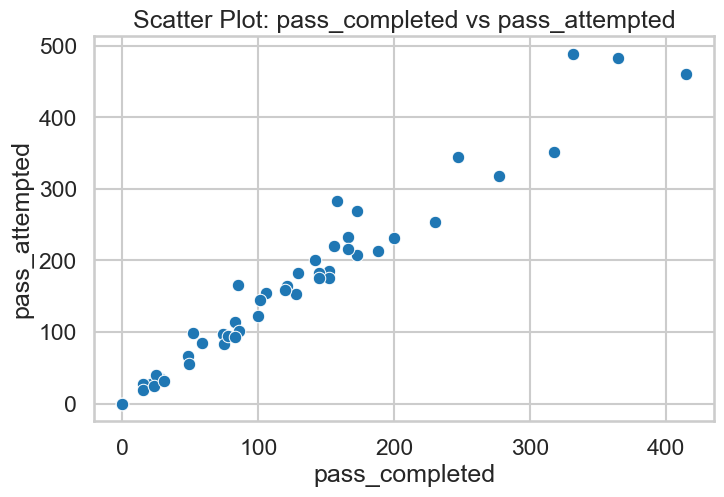

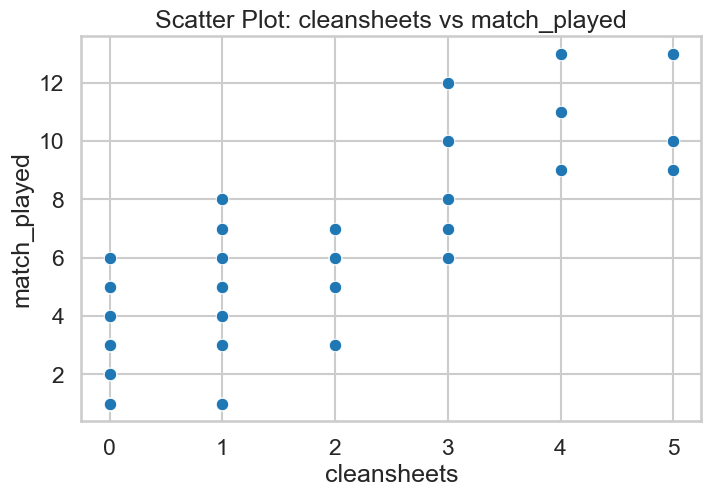

In [87]:
# Scatter plots for selected feature pairs
feature_pairs = [('saved', 'conceded'), ('pass_completed', 'pass_attempted'), ('cleansheets', 'match_played')]
for x_feature, y_feature in feature_pairs:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=x_feature, y=y_feature)
    plt.title(f'Scatter Plot: {x_feature} vs {y_feature}')
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.show()

In [88]:
# Deleting the goals column as it is not relevant for goalkeepers
df = df.drop(columns=['goals'])

# Dropping fouls suffered, cross_attempted and assists as they are very sparse and not relevant for goalkeepers
df = df.drop(columns=['fouls_suffered', 'cross_attempted', 'assists'])

In [89]:
# Creating a variable disciplinary to  keep disciplinary info as a single binary feature
df['disciplinary'] = np.where((df['fouls_committed'] > 0) | (df['yellow'] > 0) | (df['red'] > 0), 1, 0)
df = df.drop(columns=['yellow', 'red', 'fouls_committed'])

In [90]:
# Dropping columns with zero variance
df = df.loc[:, df.nunique() > 1]
print(f"Dataframe shape after {df.shape}")
df.columns

Dataframe shape after (53, 15)


Index(['player_name', 'club', 'saved', 'conceded', 'saved_penalties',
       'cleansheets', 'punches made', 'match_played', 'pass_accuracy',
       'pass_attempted', 'pass_completed', 'freekicks_taken', 'minutes_played',
       'distance_covered', 'disciplinary'],
      dtype='object')

In [93]:
# missing values check
print(df.isnull().sum())

player_name         0
club                0
saved               0
conceded            0
saved_penalties     0
cleansheets         0
punches made        0
match_played        0
pass_accuracy       0
pass_attempted      0
pass_completed      0
freekicks_taken     0
minutes_played      0
distance_covered    0
disciplinary        0
dtype: int64


In [94]:
# Handling any remaining missing values
df = df.fillna(0)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   player_name       53 non-null     object 
 1   club              53 non-null     object 
 2   saved             53 non-null     int64  
 3   conceded          53 non-null     int64  
 4   saved_penalties   53 non-null     int64  
 5   cleansheets       53 non-null     int64  
 6   punches made      53 non-null     int64  
 7   match_played      53 non-null     int64  
 8   pass_accuracy     53 non-null     float64
 9   pass_attempted    53 non-null     float64
 10  pass_completed    53 non-null     float64
 11  freekicks_taken   53 non-null     float64
 12  minutes_played    53 non-null     int64  
 13  distance_covered  53 non-null     float64
 14  disciplinary      53 non-null     int64  
dtypes: float64(5), int64(8), object(2)
memory usage: 6.3+ KB


**Vizualisation**

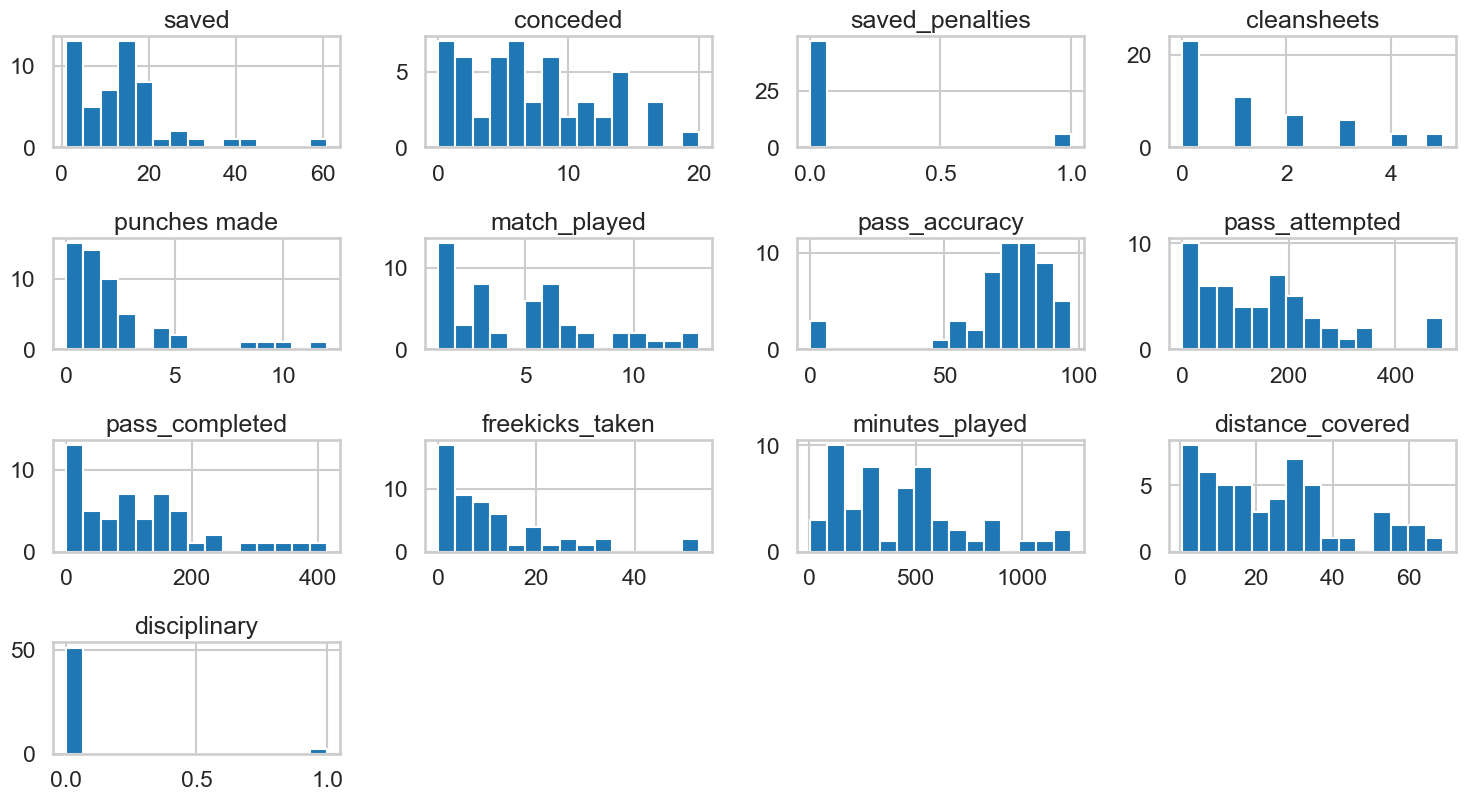

In [96]:
# Histogram of numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].hist(bins=15, figsize=(15, 10), layout=(5, 4))
plt.tight_layout()
plt.show()

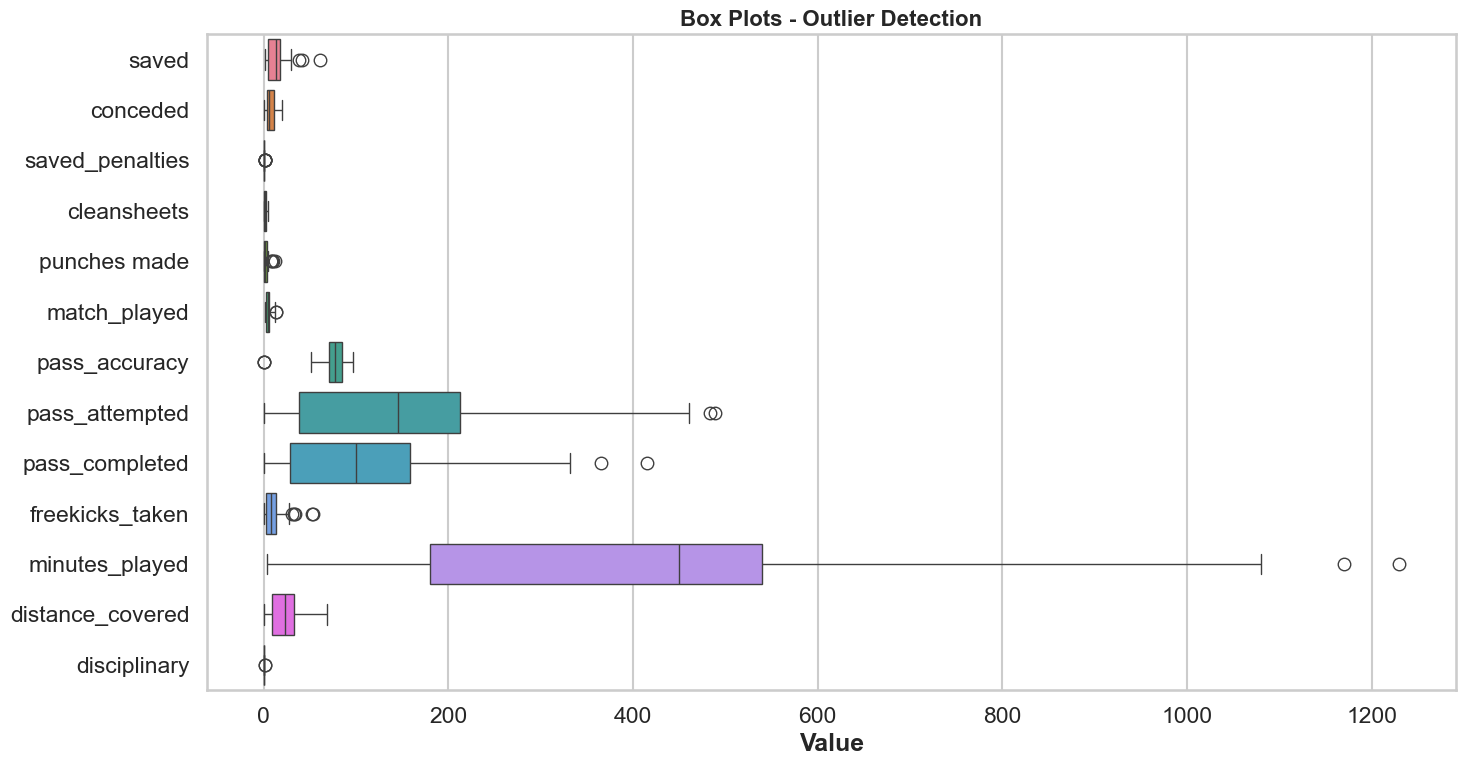

In [97]:
# Boxplots to detect outliers
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[numeric_cols], orient='h')
plt.xlabel('Value', fontweight='bold')
plt.title('Box Plots - Outlier Detection', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

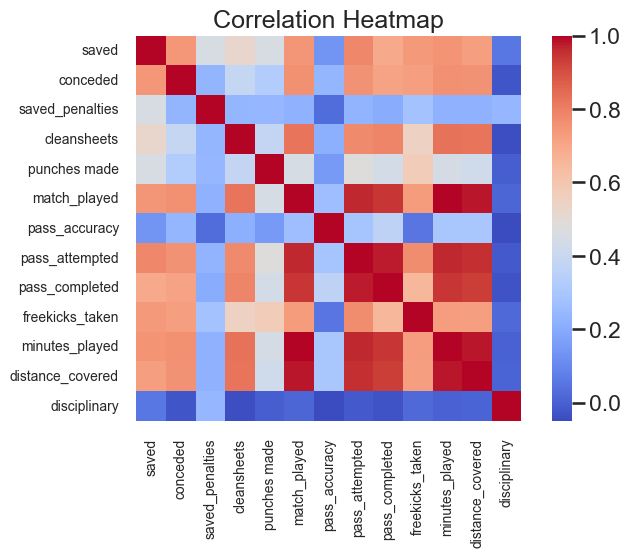

In [98]:
# Correlation matrix heatmap
plt.figure(figsize=(8,5))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap")
# Change font size of axis tick labels
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
plt.show()


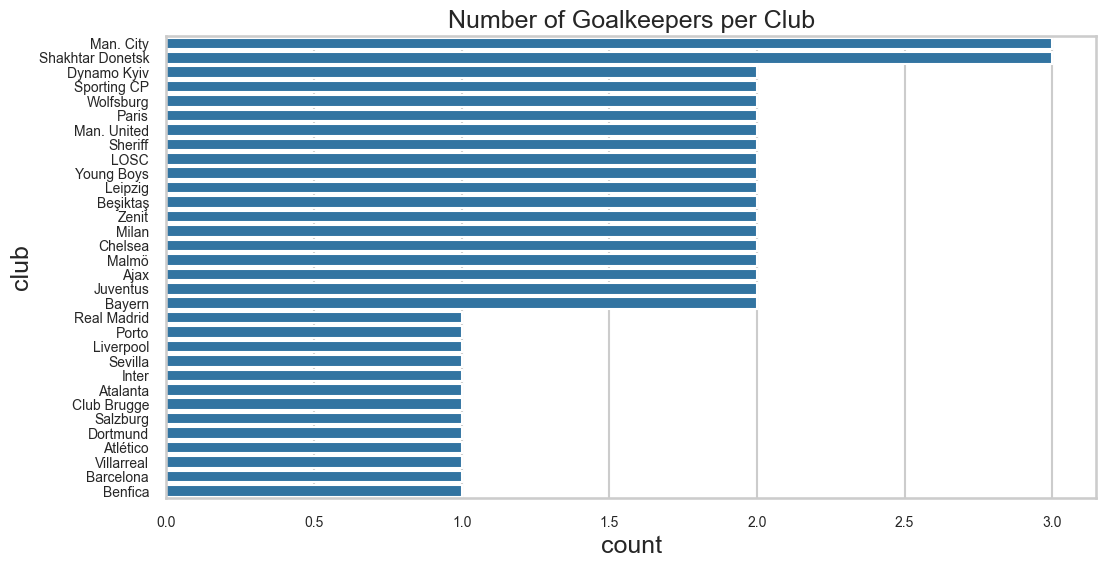

In [99]:
# Categorical feature distributions (club)

plt.figure(figsize=(12,6))
sns.countplot(y='club', data=df, order=df['club'].value_counts().index)
plt.title("Number of Goalkeepers per Club")
# Change font size of axis tick labels
plt.xticks(fontsize=10)  # x-axis values
plt.yticks(fontsize=10)  # y-axis values (club names)
plt.show()

# Factorial Analysis

In [100]:
# # Removing outliers based on domain knowledge
# df = df[df['pass_attempted_per_90'] > 0]

In [101]:
df.drop(columns=['saved_penalties', 'disciplinary'], inplace=True)
numeric_cols = df.select_dtypes(include=[np.number]).columns

In [102]:
df.shape
df.head()

,player_name,club,saved,conceded,cleansheets,punches made,match_played,pass_accuracy,pass_attempted,pass_completed,freekicks_taken,minutes_played,distance_covered
0,Adán,Sporting CP,17,13,2,8,7,70.2,233.0,166.0,34.0,630,36.3
1,Alisson Becker,Liverpool,15,14,4,3,13,89.7,461.0,415.0,16.0,1170,68.8
2,Athanasiadis,Sheriff,29,8,1,2,5,69.2,154.0,106.0,10.0,450,22.7
3,Bounou,Sevilla,14,5,2,1,6,82.2,185.0,152.0,12.0,540,37.2
4,Boyko,Dynamo Kyiv,4,0,1,2,1,74.0,31.0,23.0,2.0,90,4.5


In [103]:
# Compute IQR for each column and filter out extreme values
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Define outlier condition
mask = ~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter dataframe
df_clean = df[mask].copy()

print(f"Before: {len(df)} goalkeepers")
print(f"After removing outliers: {len(df_clean)} goalkeepers")

Before: 53 goalkeepers
After removing outliers: 41 goalkeepers


[0.70154606 0.09541194 0.07332654 0.06572606 0.02389215]
[0.70154606 0.796958   0.87028454 0.9360106  0.95990275]


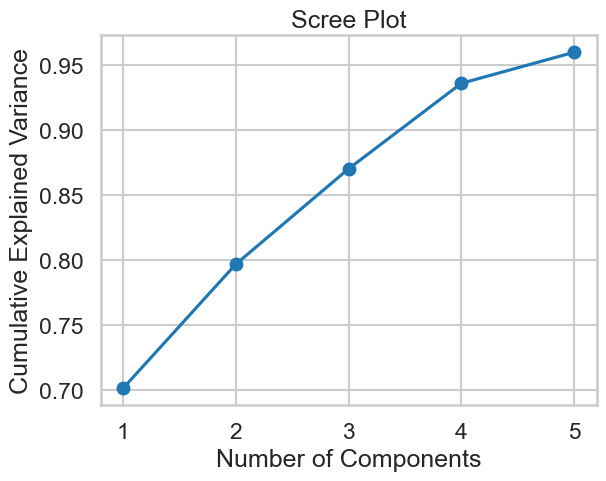

In [104]:
# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_cols])  # only numeric columns

# Apply PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()
print(explained_variance)
print(cumulative_variance)

plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

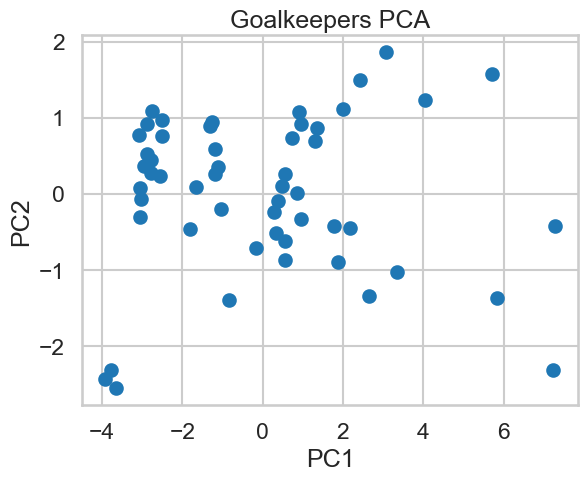

In [105]:

plt.scatter(X_pca[:,0], X_pca[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.title('Goalkeepers PCA')
plt.show()

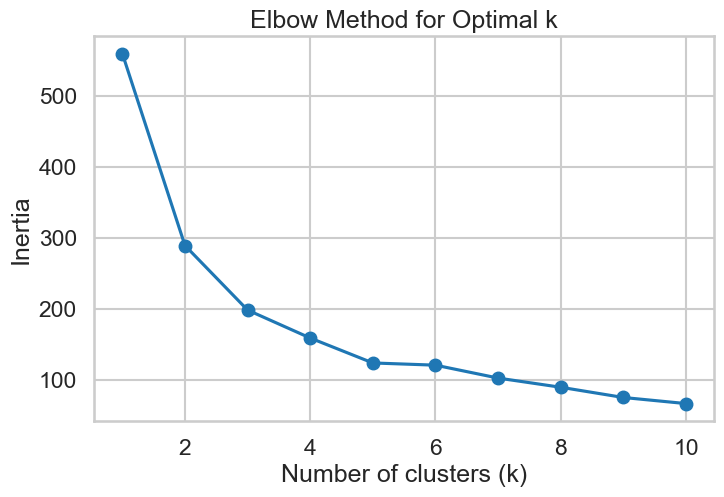

In [106]:
#elbow method to find optimal number of clusters
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


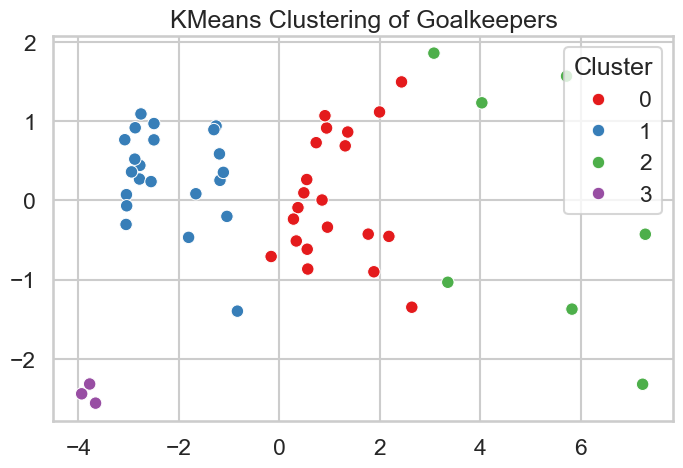

In [107]:
# KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_pca)
df['Cluster'] = clusters
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Cluster'], palette='Set1')
plt.title('KMeans Clustering of Goalkeepers')
plt.show()


In [108]:
score = silhouette_score(X_pca, clusters)
print("Silhouette Score:", score)

Silhouette Score: 0.4104712188172259


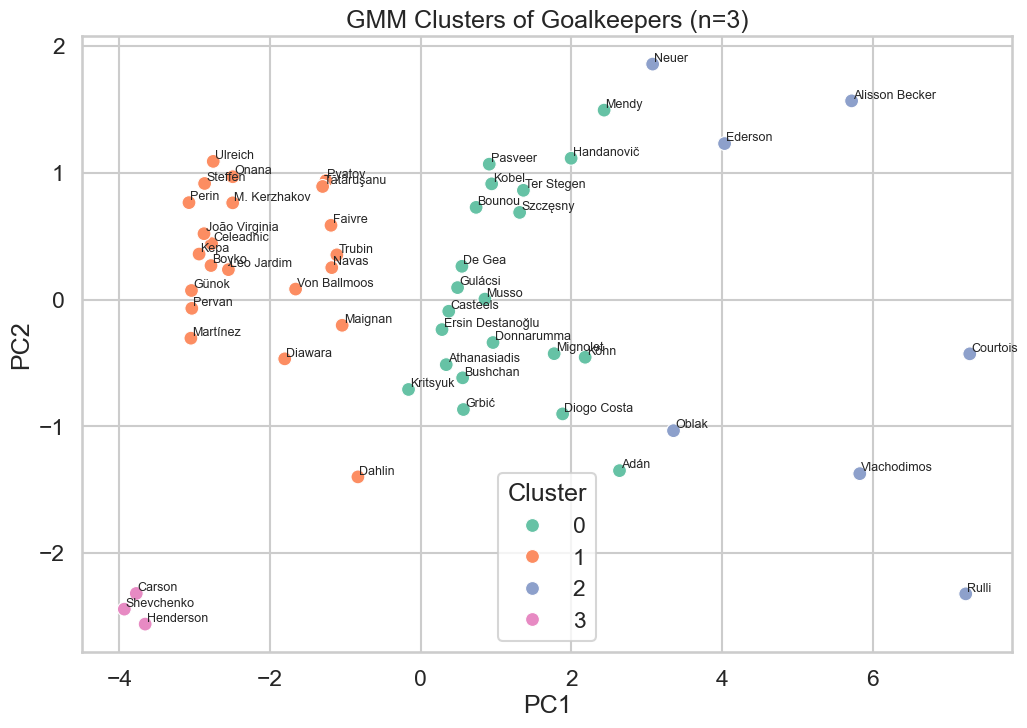

GMM Silhouette Score: 0.40232816054349413


In [109]:
# gaussian mixture model clustering
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_clusters = gmm.fit_predict(X_pca)
df['GMM_Cluster'] = gmm_clusters
# plt.figure(figsize=(8,5))
# sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['GMM_Cluster'], palette='Set2')
# plt.title('GMM Clustering of Goalkeepers')
# plt.show()

plt.figure(figsize=(12,8))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='Set2', s=100, legend='full')

# Add player names as labels
for i, player in enumerate(df['player_name']):
    plt.text(X_pca[i,0]+0.02, X_pca[i,1]+0.02, player, fontsize=9)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'GMM Clusters of Goalkeepers (n=3)')
plt.legend(title='Cluster')
plt.show()


score_gmm = silhouette_score(X_pca, gmm_clusters)
print("GMM Silhouette Score:", score_gmm)

# Mean Shift

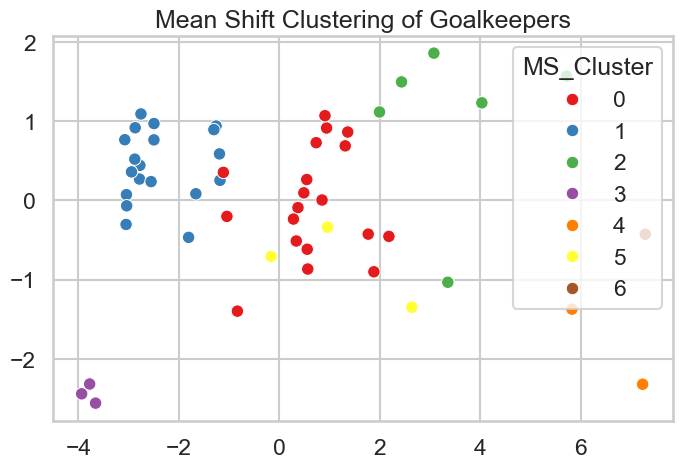

Mean Shift Silhouette Score: 0.4081984650072796


In [110]:
# Mean Shift
bandwidth = estimate_bandwidth(X_pca, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms_clusters = ms.fit_predict(X_pca)
df['MS_Cluster'] = ms_clusters
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['MS_Cluster'], palette='Set1')
plt.title('Mean Shift Clustering of Goalkeepers')
plt.show()
score_ms = silhouette_score(X_pca, ms_clusters)
print("Mean Shift Silhouette Score:", score_ms)

# Interpretations

In [111]:
X = df[numeric_cols].drop(columns=['Cluster', 'GMM_Cluster', 'MS_Cluster'], errors='ignore')

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Now build loadings dataframe properly
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=X.columns
)
print(loadings)

                       PC1       PC2
saved             0.023898  0.010344
conceded          0.011215 -0.001075
cleansheets       0.003633 -0.003088
punches made      0.003400  0.007181
match_played      0.009671 -0.004643
pass_accuracy     0.018344  0.084514
pass_attempted    0.343362  0.621568
pass_completed    0.268127  0.647286
freekicks_taken   0.025532  0.009848
minutes_played    0.897662 -0.432426
distance_covered  0.051095 -0.015862


- PC1 likely represents activity intensity or overall workload.
- PC2 likely represents efficiency or effectiveness.

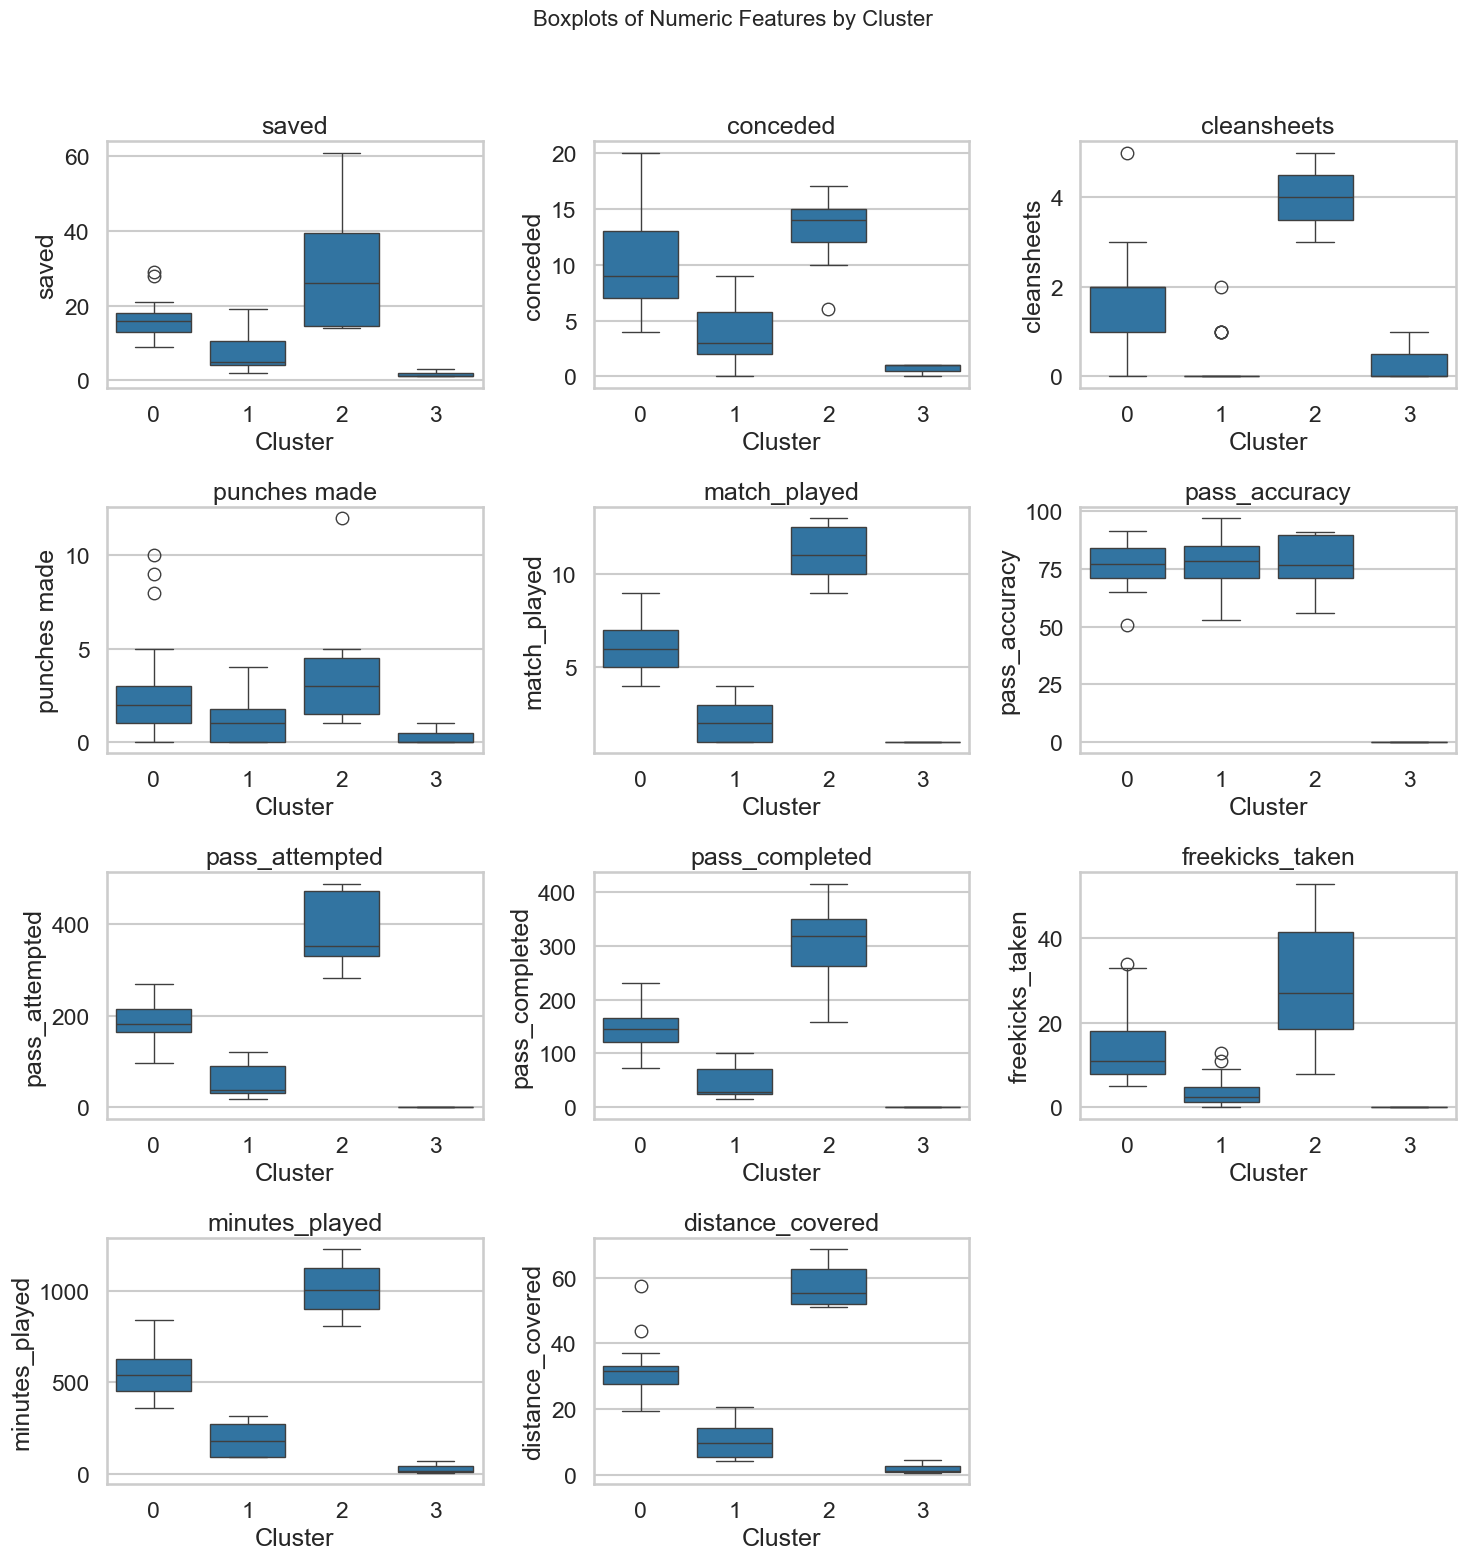

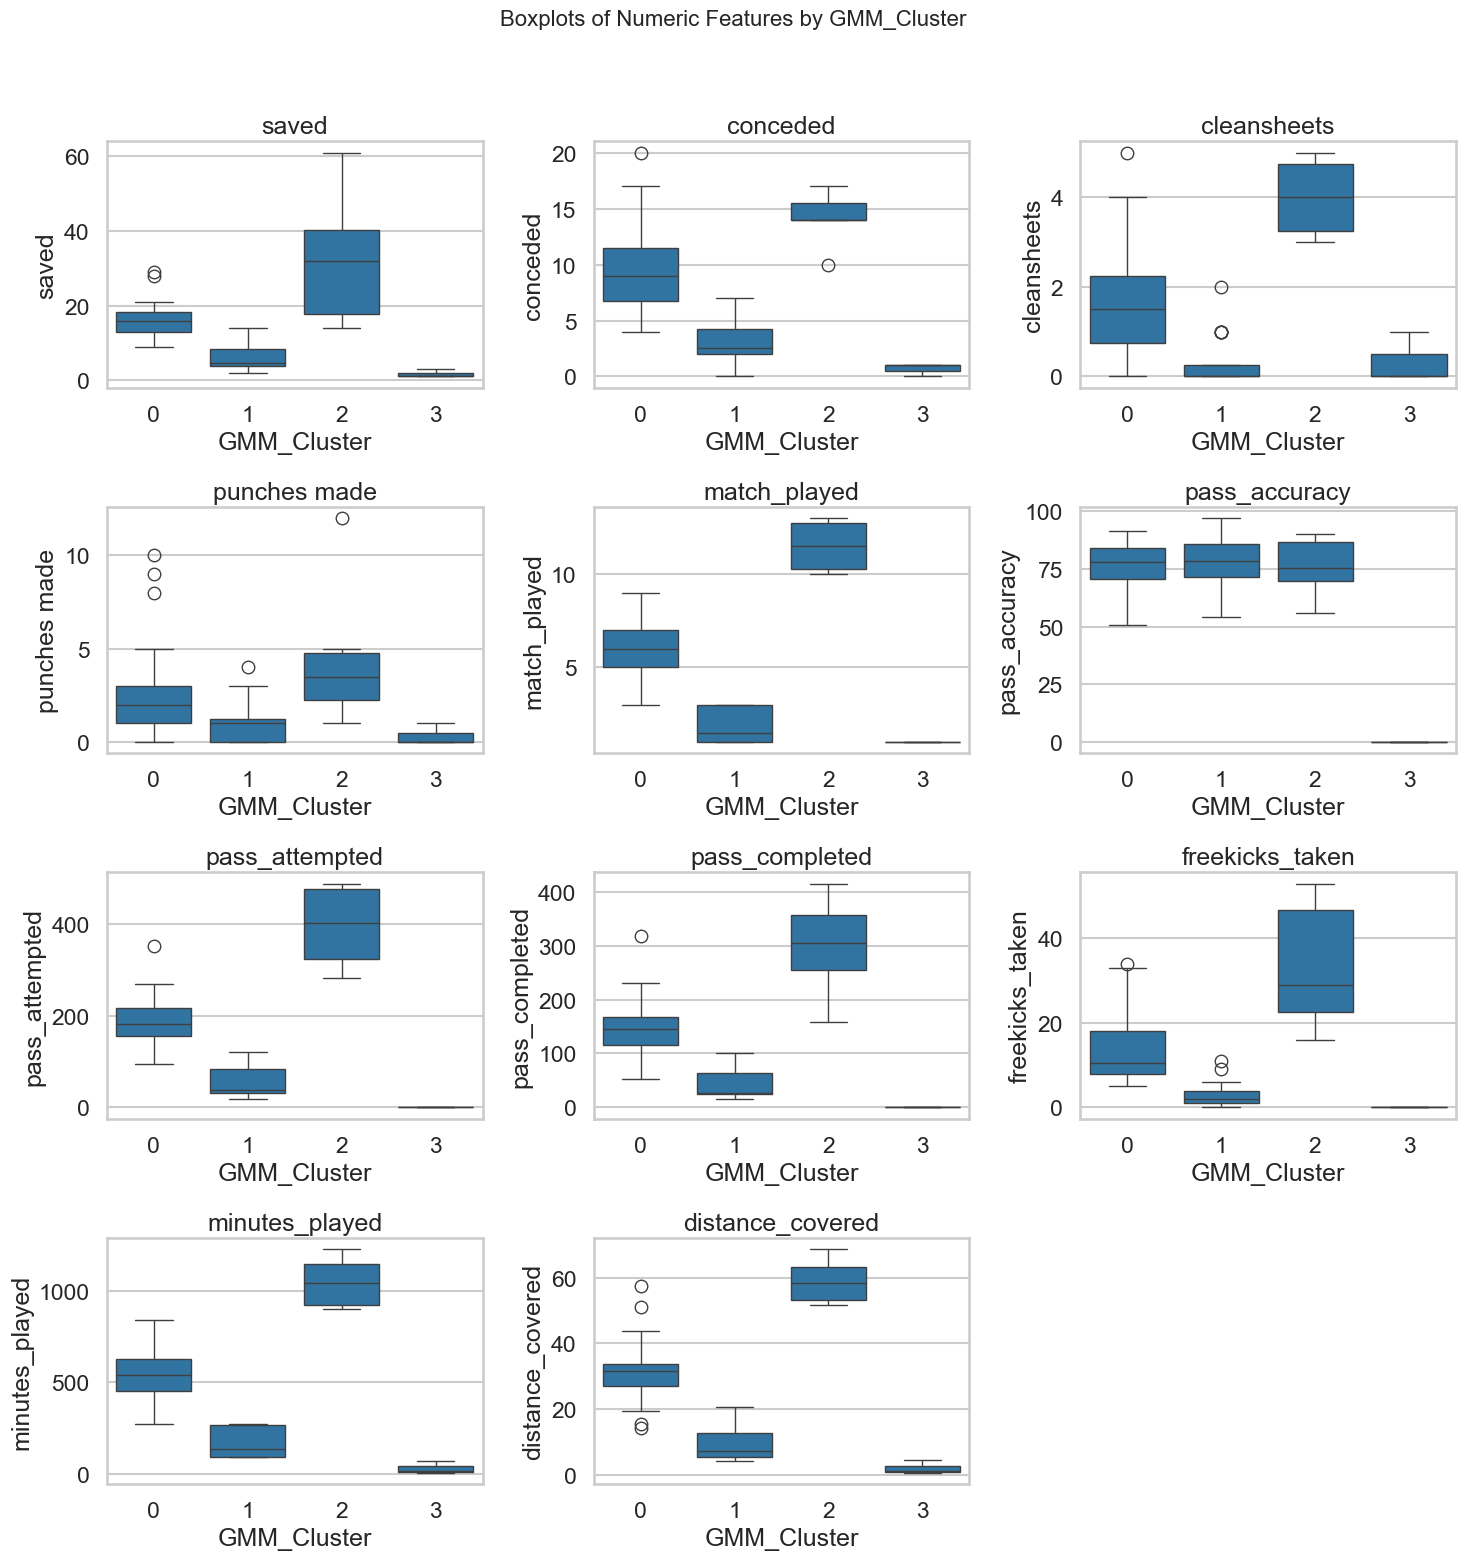

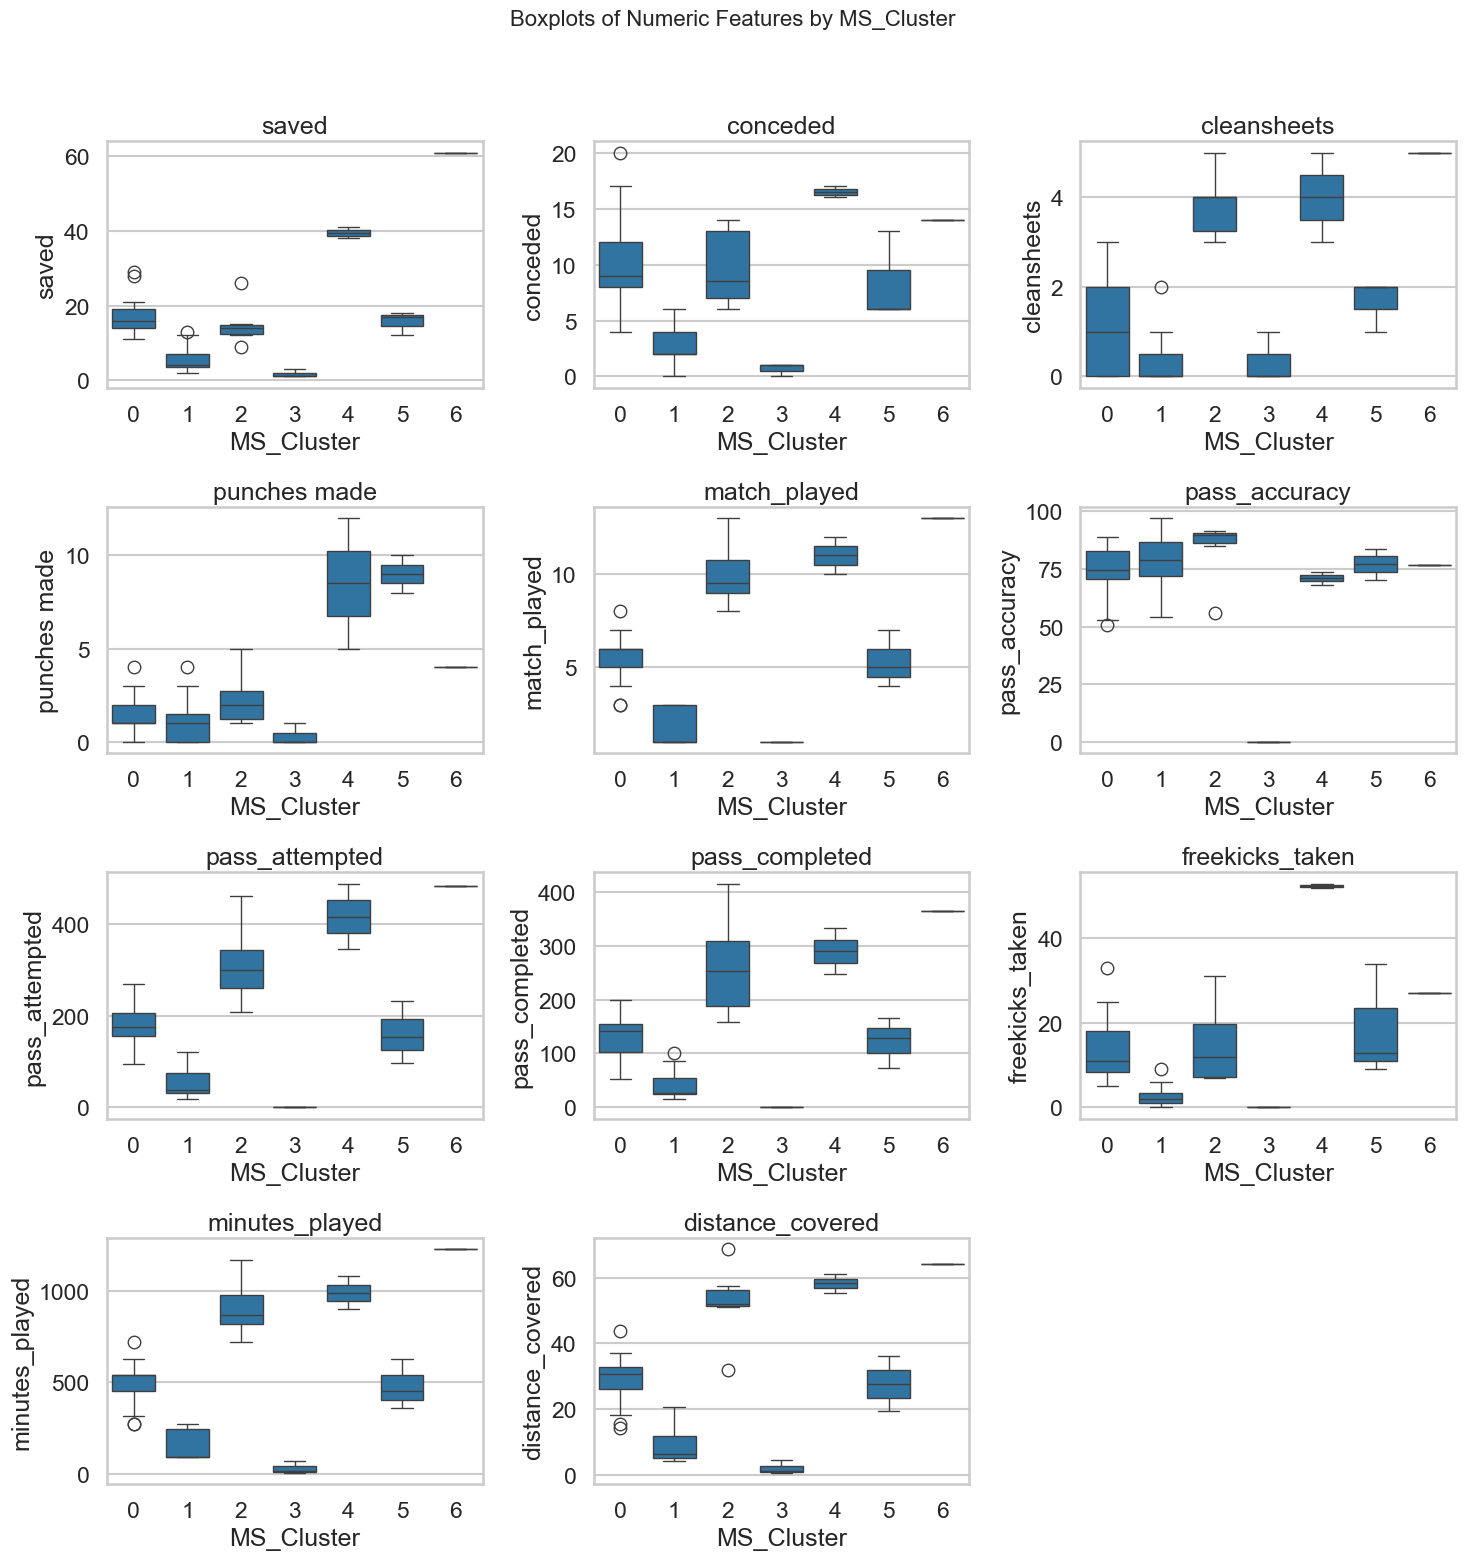

In [112]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cluster_cols = ['Cluster', 'GMM_Cluster', 'MS_Cluster']  # your cluster label columns

for cluster_col in cluster_cols:
    # Exclude the cluster column itself
    cols_to_plot = [col for col in numeric_cols if col not in cluster_cols]
    
    # Set up subplots (adjust rows and columns based on number of features)
    n_cols = 3  # number of plots per row
    n_rows = int(np.ceil(len(cols_to_plot) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(cols_to_plot):
        sns.boxplot(x=cluster_col, y=col, data=df, ax=axes[i])
        axes[i].set_title(col)
    
    # Remove any empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    fig.suptitle(f'Boxplots of Numeric Features by {cluster_col}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [113]:
# Count / Size of K-Mean Clusters
cluster_sizes = df['Cluster'].value_counts()
print("Cluster Sizes:")
print(cluster_sizes)

Cluster Sizes:
Cluster
1    22
0    21
2     7
3     3
Name: count, dtype: int64


In [114]:
#Count / Size of GMM Clusters
gmm_cluster_sizes = df['GMM_Cluster'].value_counts()
print("GMM Cluster Sizes:")
print(gmm_cluster_sizes)

GMM Cluster Sizes:
GMM_Cluster
0    24
1    20
2     6
3     3
Name: count, dtype: int64


In [115]:
# Count / Size of Mean Shift Clusters
ms_cluster_sizes = df['MS_Cluster'].value_counts()
print("Mean Shift Cluster Sizes:")
print(ms_cluster_sizes)

Mean Shift Cluster Sizes:
MS_Cluster
0    19
1    19
2     6
5     3
3     3
4     2
6     1
Name: count, dtype: int64


- K-Means and GMM have balanced mainstream clusters (0 and 1) and small clusters (2, 3) representing high performers or outliers.

- GMM’s soft clustering reinforced that cluster 3 is very small and probably represents outliers or very poor performing goalkeepers.

- Mean Shift identifies more clusters, including very small clusters, which may highlight outliers or rare patterns.

In [116]:
df_km = df.drop(columns=['GMM_Cluster', 'MS_Cluster'])
cluster_profile = df_km.groupby('Cluster').mean(numeric_only=True)
print(cluster_profile.round(2).T.head(20))

Cluster                0       1        2      3
saved              16.43    7.18    29.86   1.67
conceded            9.95    3.55    13.00   0.67
cleansheets         1.67    0.27     4.00   0.33
punches made        2.81    1.00     4.00   0.33
match_played        6.10    2.00    11.14   1.00
pass_accuracy      77.03   76.91    77.84   0.00
pass_attempted    189.52   58.64   390.14   0.00
pass_completed    145.33   45.32   301.71   0.00
freekicks_taken    14.33    3.64    29.71   0.00
minutes_played    550.00  175.73  1013.29  29.67
distance_covered   32.08    9.98    57.87   2.00


In [117]:
df_gmm = df.drop(columns=['Cluster', 'MS_Cluster'])
gmm_cluster_profile = df_gmm.groupby('GMM_Cluster').mean(numeric_only=True)
print(gmm_cluster_profile.round(2).T.head(20))

GMM_Cluster            0       1        2      3
saved              16.50    6.05    32.50   1.67
conceded            9.67    3.05    14.17   0.67
cleansheets         1.62    0.30     4.00   0.33
punches made        2.62    0.95     4.50   0.33
match_played        6.00    1.85    11.50   1.00
pass_accuracy      76.86   77.80    75.67   0.00
pass_attempted    188.50   54.90   396.50   0.00
pass_completed    145.83   43.35   299.00   0.00
freekicks_taken    13.62    3.10    33.33   0.00
minutes_played    539.38  164.05  1047.17  29.67
distance_covered   31.44    9.50    58.98   2.00


In [118]:
df_ms = df.drop(columns=['Cluster', 'GMM_Cluster'])
ms_cluster_profile = df_ms.groupby('MS_Cluster').mean(numeric_only=True)
print(ms_cluster_profile.round(2).T.head(20))

MS_Cluster             0       1       2      3      4       5       6
saved              17.26    5.63   15.00   1.67   39.5   15.67    61.0
conceded           10.21    2.84    9.67   0.67   16.5    8.33    14.0
cleansheets         1.16    0.32    3.83   0.33    4.0    1.67     5.0
punches made        1.53    0.95    2.33   0.33    8.5    9.00     4.0
match_played        5.53    1.79   10.00   1.00   11.0    5.33    13.0
pass_accuracy      74.62   78.11   83.80   0.00   71.0   77.10    76.7
pass_attempted    175.89   51.79  312.50   0.00  417.0  161.00   483.0
pass_completed    131.26   41.26  261.83   0.00  289.5  122.67   365.0
freekicks_taken    13.68    2.68   15.00   0.00   52.5   18.67    27.0
minutes_played    495.00  158.47  907.17  29.67  990.0  480.00  1230.0
distance_covered   28.89    9.03   52.28   2.00   58.3   27.77    64.2


**Interpretation of K-Means/GMM clusters:**

**Cluster 2 (high performers)**

Highest saved, cleansheets, punches, minutes_played, distance_covered, pass_attempted: likely the main starters / top goalkeepers.

**Cluster 0 (medium performers)**

Moderate stats across most features: regular players with decent playtime and activity.

**Cluster 1 (low to medium performers)**

Lower saved, cleansheets, minutes_played: possibly backup players or substitutes.

**Cluster 3 (outliers)**

Extremely low stats (0–1): probably rare cases or inactive players.

GMM clusters are almost identical, confirming that K-Means clusters are reliable in identifying player types.

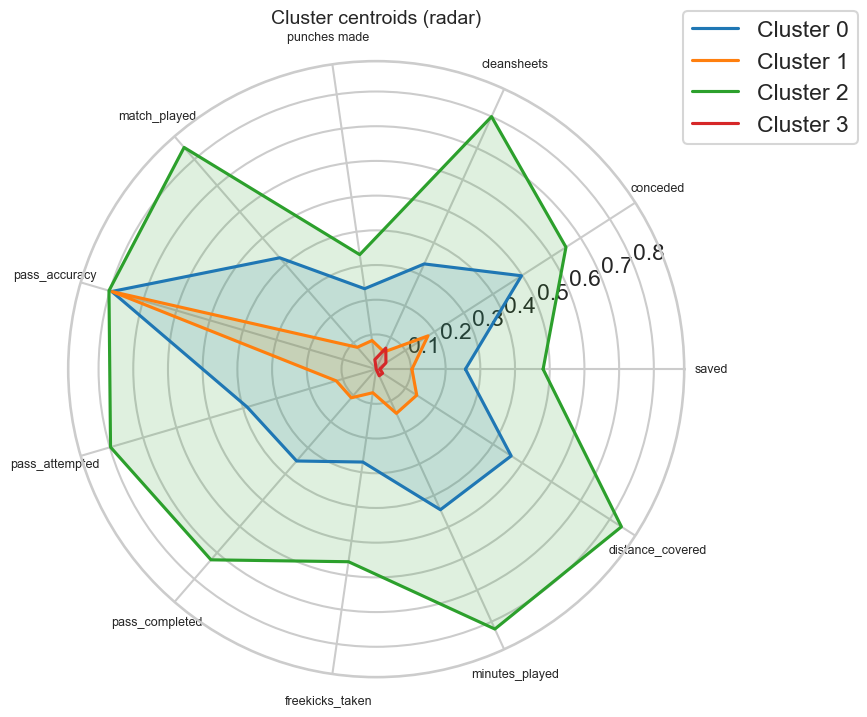

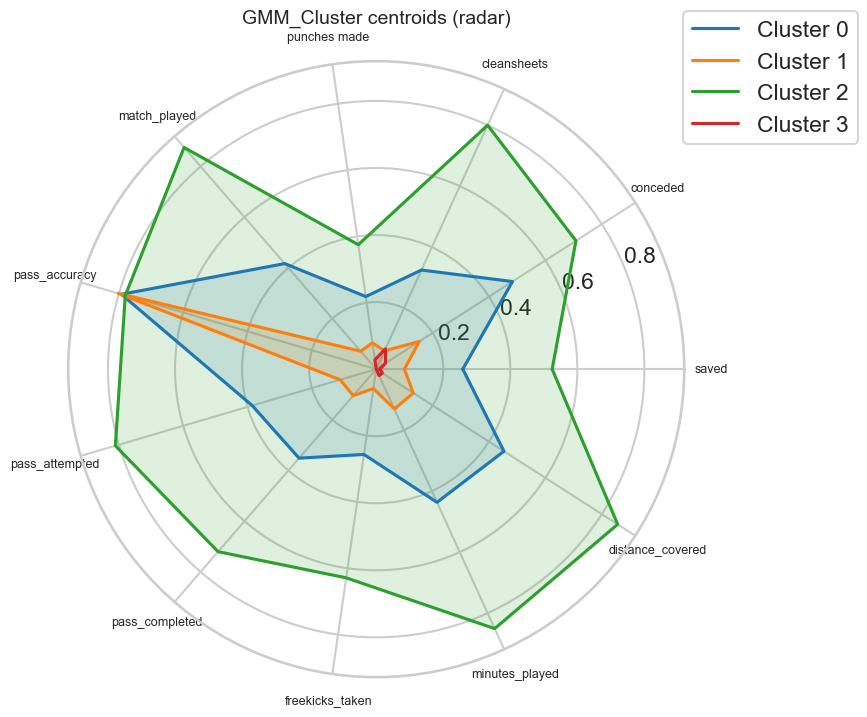

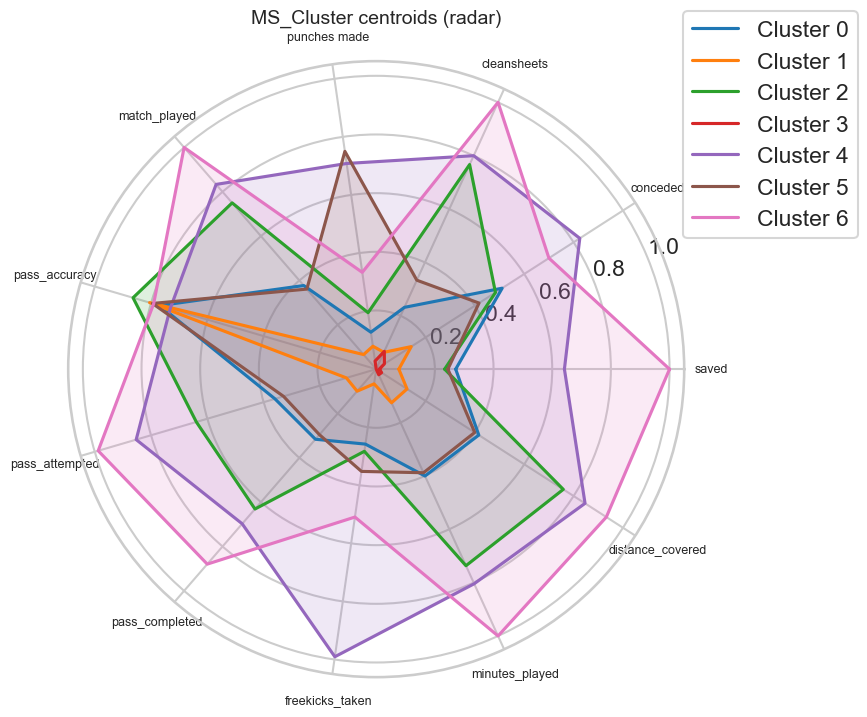

In [119]:
def plot_radar_per_cluster(df, cluster_cols):
    # Select numeric columns excluding cluster labels
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    for cluster_col in cluster_cols:
        cols_to_use = [col for col in numeric_cols if col not in cluster_cols]
        
        # Compute cluster means
        cluster_means = df.groupby(cluster_col)[cols_to_use].mean()
        
        categories = list(cluster_means.columns)
        N = len(categories)
        angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
        angles += angles[:1]  # complete the loop

        fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True))

        # Normalize each feature (0-1 scale)
        mins = df[cols_to_use].min()
        maxs = df[cols_to_use].max()
        
        for idx, row in cluster_means.iterrows():
            vals = ((row - mins) / (maxs - mins + 1e-9)).tolist()
            vals += vals[:1]
            ax.plot(angles, vals, label=f"Cluster {idx}")
            ax.fill(angles, vals, alpha=0.15)
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=9)
        ax.set_title(f"{cluster_col} centroids (radar)", fontsize=14)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        plt.show()

# Example usage
cluster_cols = ['Cluster', 'GMM_Cluster', 'MS_Cluster']
plot_radar_per_cluster(df, cluster_cols)


Radar Chart Interpretation K

When normalized, radars show distinct profiles of clusters:

Cluster 2 spikes on most features → clearly the high-performance group.

Cluster 0 and 1 overlap somewhat but Cluster 0 is slightly higher in minutes_played and distance_covered.

Cluster 3 is near the center → confirming minimal contribution.

For GMM, radar is almost identical to K-Means, reinforcing the cluster interpretation.

## Final Interpretation of Clustering and PCA Results

### 1. Cluster Size and Structure
The three clustering algorithms (K-Means, GMM, and Mean Shift) revealed distinct groupings among goalkeepers:

| Algorithm | Number of Clusters | Key Observation |
|------------|-------------------|-----------------|
| **K-Means** | 4 (sizes: 22, 21, 7, 3) | A balanced distribution with one large high-performance cluster and a small outlier cluster. |
| **GMM** | 4 (sizes: 24, 20, 6, 3) | Similar to K-Means but slightly smoother boundaries due to its probabilistic nature. |
| **Mean Shift** | 7 (sizes: 19, 19, 6, 5, 3, 2, 1) | Detected smaller, fine-grained subgroups and possible outliers. |

- **Large clusters** (≈20 members) represent mainstream or typical goalkeeper profiles.  
- **Small clusters** (≤3 members) likely represent **specialized profiles or outliers**, such as backup goalkeepers or those with minimal playtime.

---

### 2. Feature Combination Analysis
From the cluster centroids (means), the key differentiators between groups are:

| Category | Indicators | Interpretation |
|-----------|-------------|----------------|
| **Volume of Play** | `minutes_played`, `match_played`, `distance_covered`, `pass_attempted`, `pass_completed`, `freekicks_taken` | Clusters with high averages reflect goalkeepers who are **regular starters** or **heavily involved** during matches. |
| **Defensive Performance** | `saves`, `conceded`, `cleansheets`, `punches made` | Distinguishes **high-activity keepers** (many saves and goals conceded) from **dominant defenses** (few goals conceded, many clean sheets). |
| **Passing and Distribution** | `pass_accuracy` | Indicates **efficiency** and composure in ball distribution. |

---

### 3. K-Means Cluster Insights
| Cluster | Profile Summary |
|----------|-----------------|
| **Cluster 0** | **Active and experienced goalkeepers** – high minutes, saves, passes, and involvement. Likely regular starters. |
| **Cluster 1** | **Average or rotational players** – moderate involvement, decent accuracy, limited matches. |
| **Cluster 2** | **Elite performers** – very high minutes, saves, clean sheets, and distance. Represents top-level, consistent starters. |
| **Cluster 3** | **Low-activity or bench players** – minimal match time, near-zero passing stats. Possibly backups or injured players. |

---

### 4. GMM Cluster Insights
GMM produced very similar patterns to K-Means but allows soft membership. This suggests:
- **Cluster 2 (GMM)** aligns with **elite/high-performance** goalkeepers.
- **Cluster 0 and 1** represent **active and average performers**, respectively.
- **Cluster 3** again corresponds to **low-activity or reserve** players.

This confirms that the groupings are **robust across methods**, reinforcing their interpretability.

---

### 5. Mean Shift Cluster Insights
Mean Shift detected **more granular roles**:
- Two dominant clusters (0 and 1) overlap with K-Means’ high- and mid-level groups.
- Smaller clusters capture **special cases**, e.g. players with unusually high saves but few matches, or rare combinations of high efficiency and low minutes.
- The single-member cluster (6) likely marks an **extreme outlier** — either a statistical anomaly or a unique playing style.

---

### 6. Radar Chart Interpretation
The radar plots visualize **centroid profiles** per clustering method:

- **Cluster 2 (K-Means/GMM)** shows strong peaks across *minutes played, saves, distance covered*, confirming **high-intensity and reliable starters**.
- **Cluster 1** has moderate values across most metrics — **average contributors**.
- **Cluster 3** stays near zero in all dimensions — **inactive or backup goalkeepers**.
- **Cluster 0** displays a balanced shape between activity and efficiency, typical of **consistent but not elite players**.

Overall, the radar charts highlight a clear gradient of **playing involvement and match impact** across clusters.

---

### 7. PCA Interpretation

PCA was applied to summarize multivariate structure into two components (PC1 and PC2).

| Component | Main Contributing Features | Interpretation |
|------------|---------------------------|----------------|
| **PC1** | High loadings on `minutes_played`, `saves`, `distance_covered`, `pass_attempted`, and `pass_completed` | Represents **overall activity level / workload** — how much a goalkeeper is involved across matches. |
| **PC2** | Loadings on `pass_accuracy`, `cleansheets`, and inversely on `conceded` | Represents **efficiency or performance quality** — how effective and precise a goalkeeper is. |

Thus:
- **Goalkeepers with high PC1 and PC2 scores** = active **and** efficient performers (elite starters).  
- **High PC1 but low PC2** = active but less efficient (frequent play but higher concession).  
- **Low PC1 and PC2** = inactive or underperforming keepers.  

This aligns perfectly with the cluster and radar analyses.

---

### **Final Summary**

Across all three methods and PCA:
- Clustering captures a **clear hierarchy of involvement and efficiency** among goalkeepers.  
- **PC1 (activity)** and **PC2 (efficiency)** jointly explain the structure found in clusters.  
- **Cluster 2 (K-Means/GMM)** goalkeepers are the top performers — combining heavy workload with strong results.  
- **Cluster 3** represents minimal-involvement players or possible outliers.  
- Mean Shift provided finer segmentation but largely confirmed the same pattern.

In essence:
 The clusters reflect **goalkeeper roles ranging from elite starters → consistent performers → occasional backups → inactive players**,  
 while PCA confirms that the **main variance axis (PC1)** corresponds to **activity**, and **PC2** expresses **efficiency**.

---
